# Simulate Active Model B Dynamics

## As described in https://www.nature.com/articles/ncomms5351

### The Equations we solve are as follows:

$\dot{\phi} = -\nabla\cdot\mathbf{J}$

$\mathbf{J} = \nabla\mu + \Lambda$

$\mu = -\phi + \phi^3 -\nabla^2\phi + \lambda (\nabla \phi)^2$

where $\Lambda$ is a Gaussian White Noise. 

This set of equations becomes identical to the Cahn Hilliard equation when $\lambda=0$, but a non-zero $\lambda$ breaks the detailed balance in the standard Model B dynamics (see the above referenced paper) 

### Define Simulation Parameters

In [1]:
dt = 0.002
NX, NY = 256, 256
h = 0.5

### Define Field Parameters and Initialize the Field

In [2]:
from numpy.random import rand, randn

lam = 0.0
noise_strength = 0.01
phi0 = -0.4 # This is the initial average value of phi (=2c-1)
phi = phi0 + noise_strength * ( 0.5-rand(NX,NY) )

### Define the PDE operations using the del_operators library

In [3]:
import del_operators as dl

dl.set_periodic_bc()

def mu(phi):
    grad_phi = dl.grad(phi,h=h)
    # dl.grad has its first dimension as the dimension of the gradient.
    # Hence its shape is (2,NX,NY)
    grad_sq_phi = grad_phi[0]**2 + grad_phi[1]**2   
    return (-phi + phi**3 - dl.lap(phi,h=h) + lam*grad_sq_phi)

def current(phi):
    # Current has the dimension (2,NX,NY), the first dimension being 
    # the vector dimension (X/Y)
    return ( -dl.grad( mu(phi),h=h ) + noise_strength * randn(2,NX,NY) )

def timestep(phi):
    return (phi + dt * ( -dl.div( current(phi),h=h ) ) )

### Timestep phi and visualize

<IPython.core.display.Javascript object>


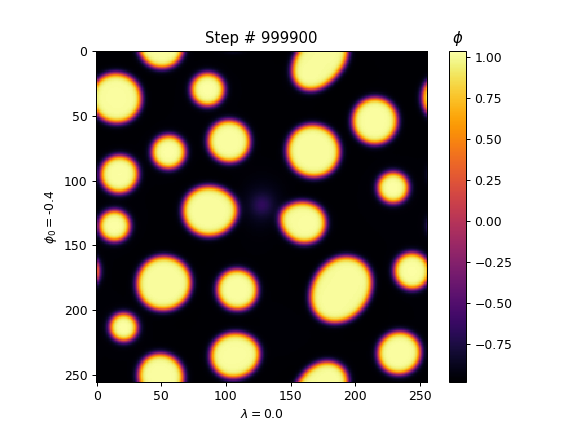

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.ion()
fig = plt.figure()
steps = 1000000
checkpoint = 100
for step in range(steps):
    if (step%checkpoint==0):
        plt.clf()
        plt.imshow(phi, cmap='inferno')
        clb = plt.colorbar()
        clb.ax.set_title(r'$\phi$')
        plt.xlabel(r"$\lambda = $" + f"{lam}")
        plt.ylabel(r"$\phi_0 = $" + f"{phi0}")
        plt.title(f'Step # {step}')
        fig.canvas.draw()
    phi = timestep(phi)
plt.ioff()
plt.show()

## Computation of the Domain Length $L(t)$

### In this section, we evaluate the domain length $L(t)$ using

### \begin{equation*}
    L(t) = 2 \pi \frac{\int S(k,t) \mathrm{d}k}{\int k S(k,t) \mathrm{d}k}
\end{equation*}

### with
### \begin{equation*}
    S(k,t) = \langle \phi(\vec{k},t)\phi(-\vec{k},t)\rangle_k
\end{equation*}

### where the average is taken over all the $\vec{k}$ that have magnitude $k$. In our case, since $\phi(x,t)$ is real valued, we have $\phi(-\vec{k},t) = \phi(\vec{k},t)^*$, and thus, the second expression reduces to 

### \begin{equation*}
    S(k,t) = \langle |\phi(\vec{k},t)|^2\rangle_k
\end{equation*}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


<IPython.core.display.Javascript object>


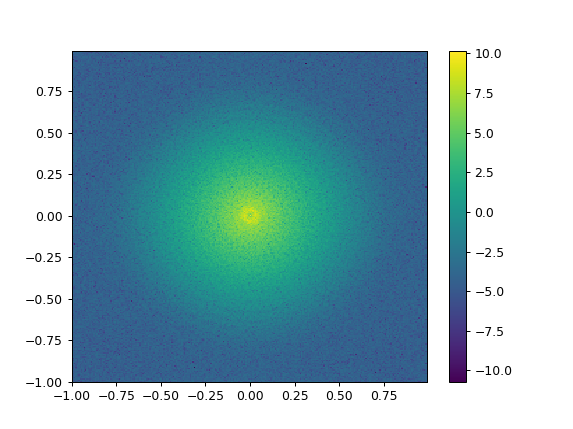

In [84]:
from numpy.fft import fft2, fftfreq, fftshift
import numpy as np
fphi = fftshift(fft2((phi)))
freq_x = fftshift(fftfreq(NX,d=h))
freq_y = fftshift(fftfreq(NY,d=h))
# The actual fft has very few large values and mostly small values.
# Hence, taking logarithm makes it easier to visualize
plt.pcolormesh(freq_x,freq_y,np.log(np.abs(fphi)))
plt.colorbar()
plt.show()

### Evaluating the Structure Factor

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


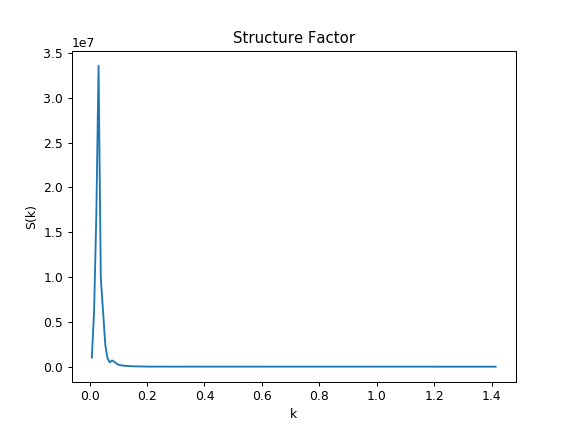

In [89]:
# Create a mesh of all the k values
kx, ky = np.meshgrid(freq_x,freq_y)
# Magnitude of the wave vector
k_mag = np.sqrt(kx**2+ky**2)
# frequency spacing
dk = freq_x[1]-freq_x[0] # You can use freq_y too in this case, since they are same

# The values of |k| for which we want the sturcture factor
ks = np.arange(0,np.amax(k_mag),dk)
# Initialize the Sturcture factor array
S = np.empty(ks.shape)
for i,k in enumerate(ks):
    # Isolate indices where k_mag is within (k,k+dk).
    condition = (k_mag>k) & (k_mag<(k+dk))
    fphi_k = fphi[condition]
    S[i] = np.mean(np.abs(fphi_k)**2)
plt.plot(ks,S)
plt.xlabel('k')
plt.ylabel('S(k)')
plt.title('Structure Factor')
plt.show()

## Visualizing $\phi(\vec{k},t)$ for a given $k$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


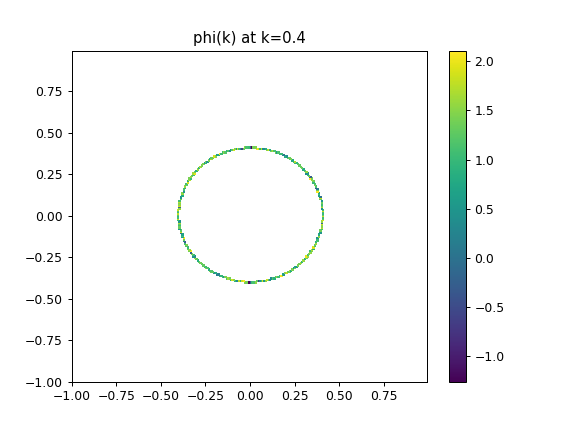

In [90]:
k0 = 0.4
condition = (k_mag>k0) & (k_mag<(k0+dk))
plt.pcolormesh(freq_x,freq_y,np.ma.masked_where(~condition,np.log(np.abs(fphi))))
plt.colorbar()
plt.title(f"phi(k) at k={k0}")
plt.show()

### Domain Length calculation to come...